In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [4]:
# Load dataset
df = pd.read_csv("lstm_ready_traffic_data.csv")
scaler = MinMaxScaler()
df['scaled_traffic_volume'] = scaler.fit_transform(df[['Total_Traffic_Volume']])
# If 'day_of_week' is text, convert to numeric
if df['day_of_week'].dtype == 'object':
    df['day_of_week'] = df['day_of_week'].astype('category').cat.codes

# Select features and target
features = ['hour', 'day_of_week', 'month', 'year', 'road_name_encoded',
            'location_encoded', 'suburb_encoded', 'average_speed',
            'maximum_speed', 'Speeding_Incident', 'Speeding_Incident_Avg_Speed']
target = 'scaled_traffic_volume'

# Convert features and target to float32 (required by LSTM)
X = df[features].values.astype('float32')
y = df[target].values.astype('float32')

# Create sequences
def create_sequences(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X, y)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, shuffle=False
)


In [6]:
!pip install keras-tuner --upgrade
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.9 MB/s eta 0:00:00


In [7]:
def build_trimodel(hp):
    model = Sequential()

    # Layer 1
    model.add(LSTM(
        units=hp.Int('lstm_units_1', min_value=32, max_value=128, step=16),
        activation='tanh',
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model.add(Dropout(hp.Float('dropout_1', 0.1, 0.4, step=0.1)))

    # Layer 2
    model.add(LSTM(
        units=hp.Int('lstm_units_2', min_value=16, max_value=64, step=16),
        activation='tanh',
        return_sequences=True
    ))
    model.add(Dropout(hp.Float('dropout_2', 0.1, 0.4, step=0.1)))

    # Layer 3
    model.add(LSTM(
        units=hp.Int('lstm_units_3', min_value=8, max_value=32, step=8),
        activation='tanh'
    ))
    model.add(Dropout(hp.Float('dropout_3', 0.1, 0.4, step=0.1)))

    # Output
    model.add(Dense(1))

    model.compile(
        optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss='mse'
    )

    return model

In [8]:
from keras_tuner.tuners import BayesianOptimization

tuner = BayesianOptimization(
    build_trimodel,
    objective='val_loss',
    max_trials=15,
    executions_per_trial=1,
    directory='traffic_tuner',
    project_name='bayesian_trimodel'
)

tuner.search(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)


Trial 15 Complete [00h 06m 39s]
val_loss: 0.007770469877868891

Best val_loss So Far: 0.006674398668110371
Total elapsed time: 01h 21m 42s


In [9]:
from tensorflow.keras.callbacks import EarlyStopping

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = best_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - loss: 0.0107 - val_loss: 0.0085
Epoch 2/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - loss: 0.0072 - val_loss: 0.0083
Epoch 3/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - loss: 0.0068 - val_loss: 0.0078
Epoch 4/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 42s 37ms/step - loss: 0.0068 - val_loss: 0.0075
Epoch 5/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - loss: 0.0064 - val_loss: 0.0074
Epoch 6/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - loss: 0.0063 - val_loss: 0.0074
Epoch 7/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 42s 37ms/step - loss: 0.0064 - val_loss: 0.0078
Epoch 8/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 43s 40ms/step - loss: 0.0061 - val_loss: 0.0079
Epoch 9/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 39s 38ms/step - loss: 0.0061 - val_loss: 0.0080
Epoch 10/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - loss: 0.0060 - val_loss: 0.0079
Epoch 11/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - loss: 0.0062 - val_loss: 0.0079


In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_pred_bayes_12 = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_bayes_12))
mae = mean_absolute_error(y_test, y_pred_bayes_12)
r2 = r2_score(y_test, y_pred_bayes_12)
mse = mean_squared_error(y_test, y_pred_bayes_12)

print("\n✅ Bayesian Optimized Trimodel Results:")
print(f"🔹 RMSE: {rmse:.4f}")
print(f"🔹 MAE : {mae:.4f}")
print(f"🔹 R²  : {r2:.4f}")
print(f"🔹 MSE : {mse:.4f}")


395/395 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step

✅ Bayesian Optimized Trimodel Results:
🔹 RMSE: 0.0860
🔹 MAE : 0.0526
🔹 R²  : 0.0486
🔹 MSE : 0.0074


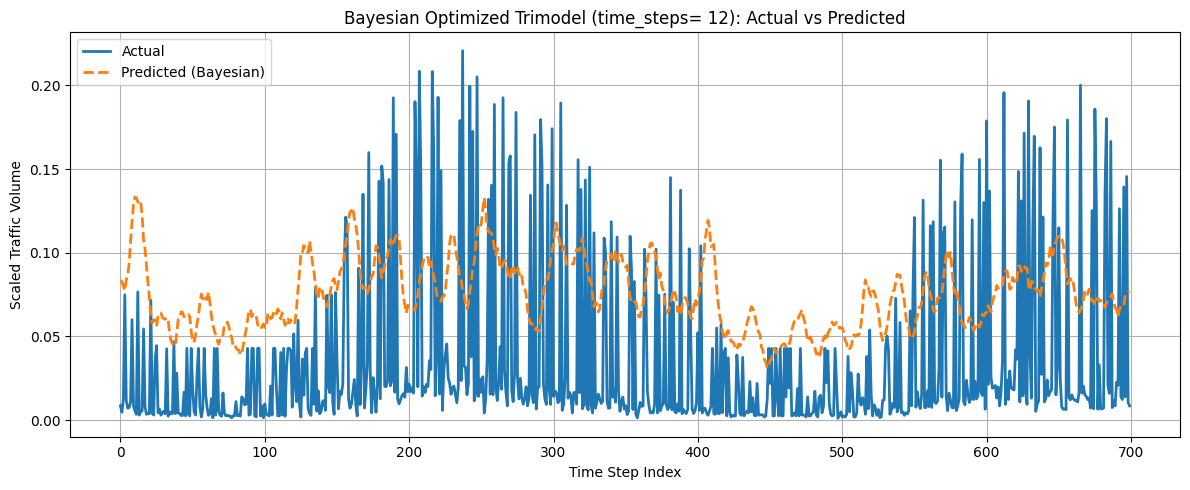

In [11]:
plt.figure(figsize=(12, 5))
plt.plot(y_test[:700], label='Actual', linewidth=2)
plt.plot(y_pred_bayes_12[:700], label='Predicted (Bayesian)', linestyle='--', linewidth=2)
plt.title("Bayesian Optimized Trimodel (time_steps= 12): Actual vs Predicted")
plt.xlabel("Time Step Index")
plt.ylabel("Scaled Traffic Volume")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
import numpy as np

np.save("y_bayesian_12.npy", y_pred_bayes_12)


In [13]:
from google.colab import files

files.download("y_bayesian_12.npy")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>